#IMPACT MED 2025
##Hands-On Workshop – Imaging AI in Action
Ernest (Khashayar) Namdar (Lead), Noushin Jafarpisheh (Co-Lead), Dr. Anastasia Oikonomou (Medical Imaging Expert)

**Applying MedGemma to Chest X-ray Data**





###File and Folder Structure
The first step in developing any AI pipeline is designing a well-structured file and directory organization. There are multiple valid approaches, and no single one is universally best. What truly matters is maintaining absolute consistency (in file names, folder names, formats, and overall organization).

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Import os and define your data directory.
import os

os.chdir('/content/drive/MyDrive/IMPACT_Med_2025/code')   # adjust path if different

# Walk over the parent directory and print file names
for root, dirs, files in os.walk("../"):
    print(f"\n Directory: {root}")
    for name in files:
        print(f"   - {name}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

 Directory: ../

 Directory: ../code
   - MedGemma_Inference.ipynb

 Directory: ../data

 Directory: ../data/DICOM

 Directory: ../data/DICOM/ID1
   - 00001_1.3.46.670589.26.802223.4.20161106.195357.606391.0.dcm
   - 00001_1.3.46.670589.26.802223.4.20161106.195418.606390.0.dcm

 Directory: ../data/DICOM/ID2
   - 00001_1.3.46.670589.30.1.6.1.966169560804.1762444146687.2.dcm

 Directory: ../data/DICOM/ID3
   - 00001_1.3.46.670589.26.802223.4.20170403.153610.638469.0.dcm
   - 00001_1.3.51.0.7.1679754061.31332.31041.47613.41254.21608.8822.dcm

 Directory: ../data/DICOM/ID4
   - 00001_1.2.840.113564.127001.20200123194934469860.2203801020003.dcm

 Directory: ../data/JPG

 Directory: ../data/JPG/Patient1
   - img_support.jpg
   - img.jpg
   - impression.txt
   - question.txt

 Directory: ../data/JPG/Patient2
   - img.jpg
   - img_support.jpg
   - question.txt
   - 

As shown, the DICOM files are not fully consistent. Some patients have two files, while others have only one. In contrast, the JPG files are uniform across all patients. Therefore, we can rely on the DICOM files for detailed case studies and use the JPG files for large-scale analyses (assuming sample size is sufficient).

In real-world scenarios, there are various workarounds for handling an inconsistent number of DICOM files per patient, and the optimal solution depends on the specific clinical question. However, in general, consistency remains a critical requirement for any large-scale analysis.

###How to Use Passwords and API Keys

You can store passwords or API keys directly as Python variables, but this approach is not secure, especially when sharing code or uploading it to repositories. The recommended method is to use the secrets module (or environment variables) to securely manage sensitive information. This keeps credentials hidden from your source code and reduces the risk of accidental exposure.

At this point you need to acquire your API key from Hugging Face
https://huggingface.co/

Hugging Face is a platform and community where a wide range of AI models and datasets are shared for public use. In our case, we obtain the MedGemma model from Hugging Face.

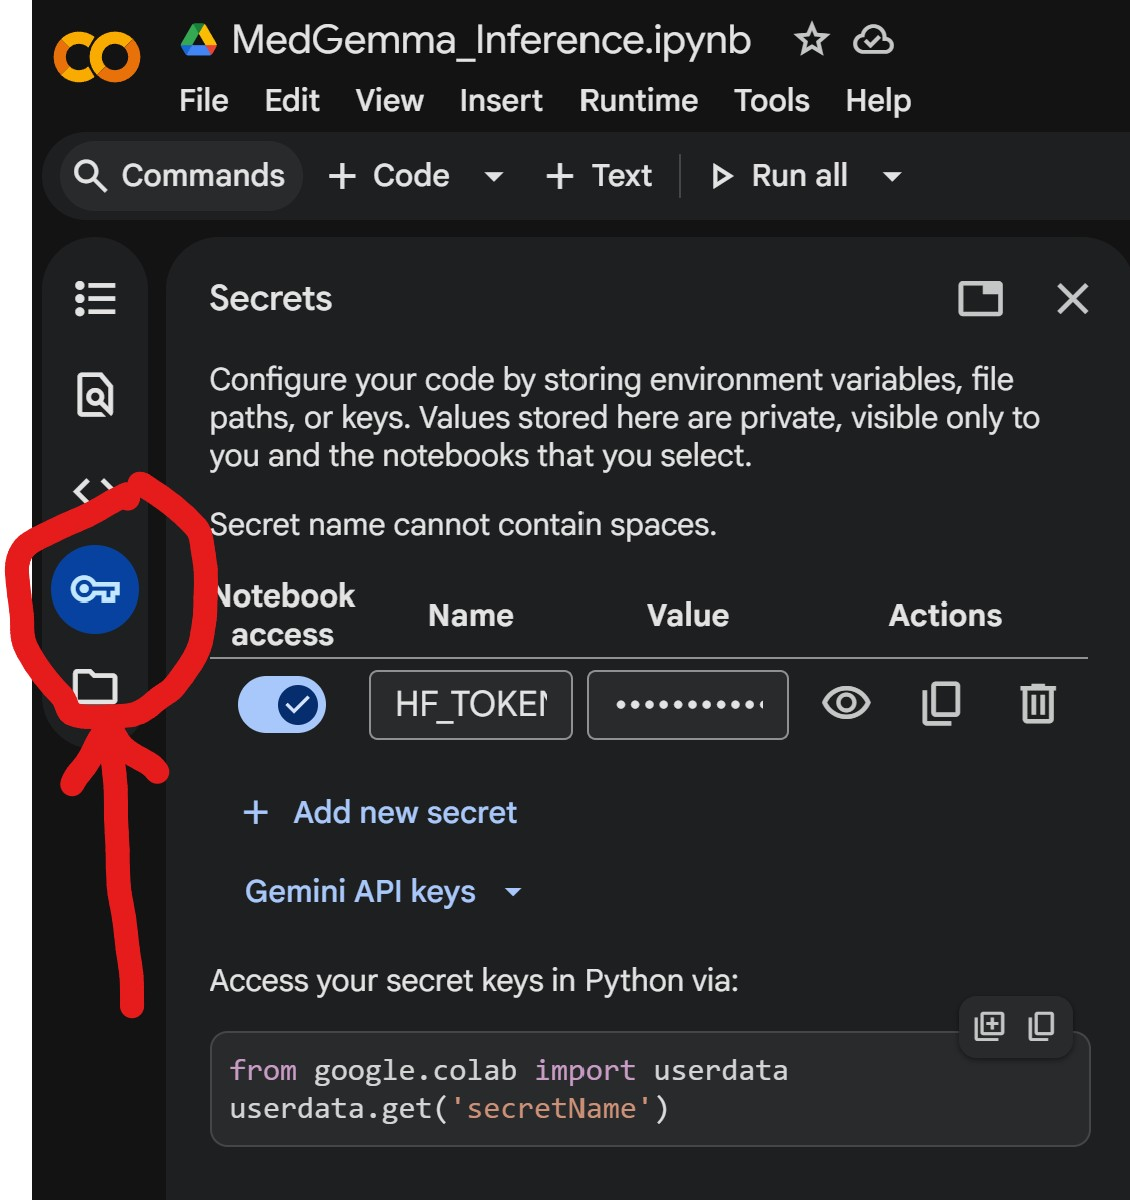

In [2]:
from google.colab import userdata
hf_token = userdata.get("HF_TOKEN")   # replace with your secret name
assert hf_token, "Grant Notebook access to the secret, then re-run this cell."

# login to Hugging Face
!pip -q install huggingface_hub
from huggingface_hub import login
login(hf_token)

### MedGemma Models on Hugging Face

MedGemma is a collection of Gemma 3 variants optimized for medical text and image understanding, enabling advanced healthcare AI applications (current versions were released in July 2025).

google/medgemma-4b-pt — 4B, pre-trained multimodal model for Image-Text-to-Text tasks; suitable for fine-tuning and customization.

google/medgemma-4b-it — 4B, instruction-tuned multimodal model for direct inference on medical cases.

google/medgemma-27b-it — 27B, instruction-tuned multimodal model with enhanced reasoning; supports image and text input.

google/medgemma-27b-text-it — 27B, instruction-tuned text-only model for medical Q&A and summarization.

google/medsiglip-448 — 0.9B vision encoder for zero-shot image classification and feature extraction.

The first step is to enable GPU support on Google Colab. You can do that through the top menu bar (Edit->Notebook setting)

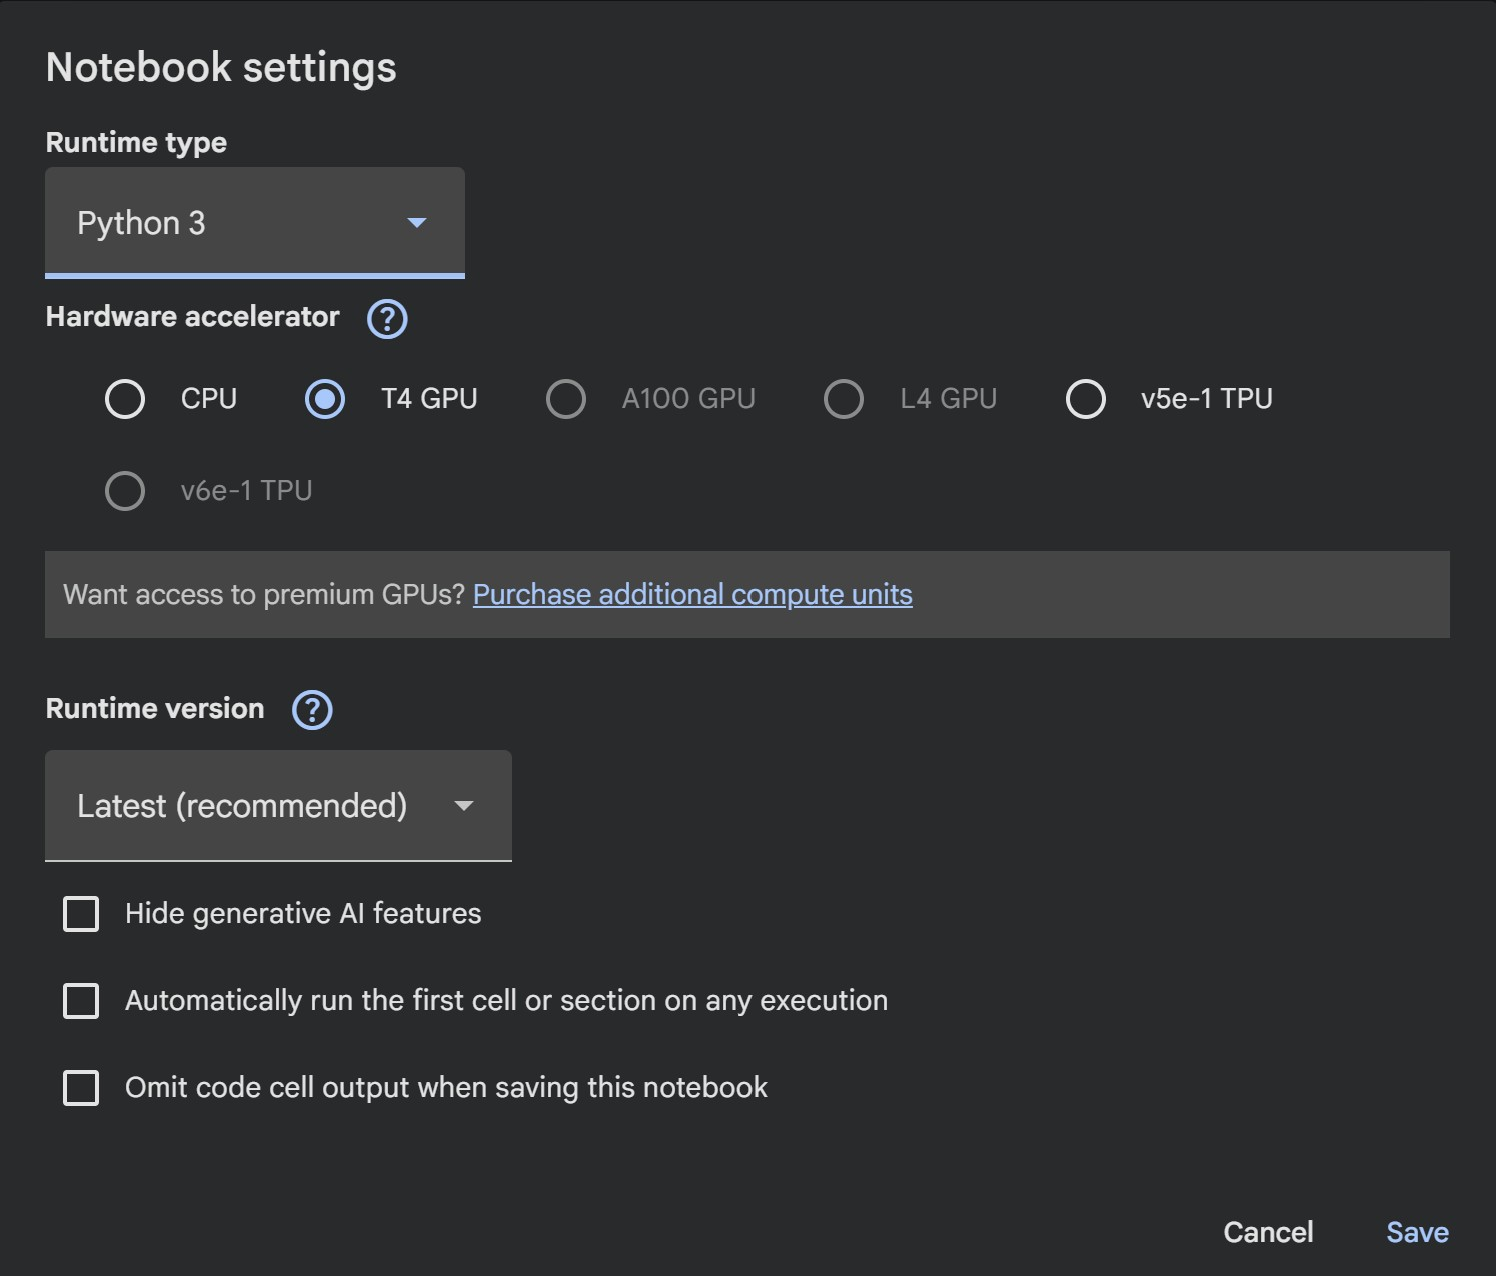

CPU → Basic processor, slower, but stable and always available.

T4 GPU → A mid-range NVIDIA GPU that supports CUDA acceleration; good for most deep learning models.

A100 GPU → A high-end GPU (premium, only with Colab Pro+); excellent for very large models like MedGemma-27B.

L4 GPU → A newer, efficient GPU (premium tier).

v5e-1 TPU / v6e-1 TPU → Google’s TPUs (Tensor Processing Units); designed for TensorFlow and JAX, not ideal for Hugging Face Transformers unless the model specifically supports TPU.

In [3]:
import os
import sys

google_colab = "google.colab" in sys.modules and not os.environ.get("VERTEX_PRODUCT") # VERTEX_PRODUCT means Running inside Colab Enterprise

if google_colab:
    print("the code is running on Colab")
    # Use secret if running in Google Colab
    from google.colab import userdata
    os.environ["HF_TOKEN"] = userdata.get("HF_TOKEN")
    os.environ["HF_HOME"] = "/content/drive/MyDrive/IMPACT_Med_2025/hf"
else:
    # put the desired config
    pass

the code is running on Colab


In [4]:
! pip install --upgrade --quiet accelerate bitsandbytes transformers


In [5]:
from transformers import BitsAndBytesConfig
import torch
import os, sys

# Detect Colab (non-Enterprise) to apply the 27B memory guard below
google_colab = "google.colab" in sys.modules and not os.environ.get("VERTEX_PRODUCT")

# ── Choose model ────────────────────────────────────────────────────────────────
# Options:
#   - "4b-pt"          → google/medgemma-4b              (multimodal, pre-trained)
#   - "4b-it"          → google/medgemma-4b-it           (multimodal, instruction-tuned)
#   - "27b-it"         → google/medgemma-27b-it          (multimodal, instruction-tuned)
#   - "27b-it-text"    → google/medgemma-27b-it-text     (text-only, instruction-tuned)
#   - "medsiglip-448"  → google/medsiglip-448            (vision encoder, zero-shot cls)
model_choice = "4b-it"  # @param ["4b-pt", "4b-it", "27b-it", "27b-it-text", "medsiglip-448"]

variant_to_hf = {
    "4b-pt":         "google/medgemma-4b",
    "4b-it":         "google/medgemma-4b-it",
    "27b-it":        "google/medgemma-27b-it",
    "27b-it-text":   "google/medgemma-27b-it-text",
    "medsiglip-448": "google/medsiglip-448",
}
model_id = variant_to_hf[model_choice]

# Decide the pipeline task based on modality
if model_choice == "27b-it-text":
    pipeline_task = "text-generation"
elif model_choice == "medsiglip-448":
    pipeline_task = "zero-shot-image-classification"
else:
    pipeline_task = "image-to-text"  # multimodal MedGemma

# ── Quantization & thinking mode flags ─────────────────────────────────────────
# Quantization is useful for large LLMs; we skip it for MedSigLIP.
use_quantization = True   # @param {type: "boolean"}
if model_choice == "medsiglip-448":
    use_quantization = False  # keep it simple/stable for vision encoder

# Thinking is supported for 27B variants only.
is_thinking = False       # @param {type: "boolean"}

# ── 27B memory guard for standard Colab ────────────────────────────────────────
if "27b" in model_choice and google_colab:
    gpu_name = torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU"
    if not ("A100" in gpu_name and use_quantization):
        raise ValueError(
            f"Runtime has insufficient memory for {model_choice}.\n"
            f"Detected: {gpu_name}\n"
            "Please select an A100 GPU and enable 4-bit quantization."
        )

# ── Common model kwargs ────────────────────────────────────────────────────────
model_kwargs = dict(
    torch_dtype=torch.bfloat16,
    device_map="auto",
)
if use_quantization:
    model_kwargs["quantization_config"] = BitsAndBytesConfig(load_in_4bit=True)

# MedSigLIP doesn’t benefit from bfloat16/4-bit here; keep defaults simple.
if model_choice == "medsiglip-448":
    model_kwargs.pop("torch_dtype", None)
    model_kwargs.pop("quantization_config", None)

print(f"Selected model: {model_id}")
print(f"Pipeline task:  {pipeline_task}")
print(f"Quantization:   {'4-bit' if use_quantization else 'disabled'}")
print(f"Thinking mode:  {is_thinking} (27B-only feature)")


Selected model: google/medgemma-4b-it
Pipeline task:  image-to-text
Quantization:   4-bit
Thinking mode:  False (27B-only feature)


In this workshop, our focus is on 4b-it, which is a multimodal and instruction-tuned of MedGemma.

In [6]:
from transformers import pipeline

if "text" in model_choice:
    pipe = pipeline("text-generation", model=model_id, model_kwargs=model_kwargs)
else:
    pipe = pipeline("image-text-to-text", model=model_id, model_kwargs=model_kwargs)

pipe.model.generation_config.do_sample = False

`torch_dtype` is deprecated! Use `dtype` instead!
`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda:0


### DICOM Dataset: Case Studies

In this section, we focus on using MedGemma to perform inference on specific cases (such as case studies).

Each Python library serves a particular purpose. For example, pydicom is a well-known library for working with DICOM files. On a personal computer, Python libraries are typically installed using pip in the terminal. In Google Colab, you can run the same installation commands by prefixing them with an exclamation mark (!), which allows you to execute shell commands directly from a notebook cell.

In [7]:
!pip install -q pylibjpeg pylibjpeg-libjpeg pylibjpeg-openjpeg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 57.9 MB/s eta 0:00:00


In [8]:
!pip install pydicom

In [9]:
import pydicom

# --- ID1 ---
ID1_image1 = pydicom.dcmread("../data/DICOM/ID1/00001_1.3.46.670589.26.802223.4.20161106.195357.606391.0.dcm")
ID1_image2 = pydicom.dcmread("../data/DICOM/ID1/00001_1.3.46.670589.26.802223.4.20161106.195418.606390.0.dcm")

# --- ID2 ---
ID2_image1 = pydicom.dcmread("../data/DICOM/ID2/00001_1.3.46.670589.30.1.6.1.966169560804.1762444146687.2.dcm")

# --- ID3 ---
ID3_image1 = pydicom.dcmread("../data/DICOM/ID3/00001_1.3.46.670589.26.802223.4.20170403.153610.638469.0.dcm")
ID3_image2 = pydicom.dcmread("../data/DICOM/ID3/00001_1.3.51.0.7.1679754061.31332.31041.47613.41254.21608.8822.dcm")

# --- ID4 ---
ID4_image1 = pydicom.dcmread("../data/DICOM/ID4/00001_1.2.840.113564.127001.20200123194934469860.2203801020003.dcm")

print("All DICOM files loaded successfully.")


All DICOM files loaded successfully.


In [10]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def analyze_dicom_with_medgemma(dicom_obj, pipe, title=None, max_new_tokens=220):
    """
    Display a DICOM image in grayscale and obtain a MedGemma report
    using a correct chat+image format, with safe fallbacks.
    """
    # --- DICOM -> normalized grayscale array ---
    arr = dicom_obj.pixel_array.astype(np.float32)
    if getattr(dicom_obj, "PhotometricInterpretation", "").upper() == "MONOCHROME1":
        arr = arr.max() - arr
    rng = np.ptp(arr)
    arr = np.zeros_like(arr) if rng == 0 else (arr - arr.min()) / rng

    # --- Plot in grayscale ---
    plt.figure(figsize=(6, 6))
    plt.imshow(arr, cmap="gray")
    plt.axis("off")
    plt.title(title or "DICOM Image")
    plt.show()

    # --- Prepare RGB image for model ---
    image = Image.fromarray((arr * 255).astype(np.uint8)).convert("RGB")

    # --- Radiology prompt ---
    prompt = (
        "Examine this chest radiograph and report:\n"
        "• Lungs & pleura (consolidation, edema, effusion, pneumothorax)\n"
        "• Cardiomediastinal contours (heart size, mediastinum)\n"
        "• Bones/soft tissues\n"
        "Mention lines/devices if present. Provide a concise Impression with the leading diagnosis and key differentials."
    )

    # Try proper chat format first (all messages use list-of-content blocks)
    messages = [
        {"role": "system", "content": [{"type": "text", "text": "You are a board-certified radiologist."}]},
        {"role": "user", "content": [
            {"type": "image"},
            {"type": "text", "text": prompt},
        ]},
    ]

    # Prefer deterministic decoding when supported
    try:
        pipe.model.generation_config.do_sample = False
    except Exception:
        pass

    try:
        # Chat format + explicit image list
        out = pipe(text=messages, images=[image], max_new_tokens=max_new_tokens)
    except Exception:
        try:
            # Fallback: inline <image> token format (many Gemma3 builds support this)
            out = pipe(text="<image>\n" + prompt, images=image, max_new_tokens=max_new_tokens)
        except Exception:
            # Text-only fallback: no image passed
            out = pipe(text=prompt, max_new_tokens=max_new_tokens)

    text = out[0].get("generated_text", out[0])
    print("\n--- MedGemma Report ---\n")
    print(text)
    return text



In [11]:
import re
from IPython.display import Markdown, display

def format_case_report(case_report, title="🩺 MedGemma Radiology Report"):
    """
    Format and display a MedGemma case report in Markdown (for Colab/Jupyter).
    Handles both text and chat-style outputs from the model.
    """
    # --- Extract assistant text safely ---
    msg = case_report[-1]
    content = msg.get("content", msg)
    if isinstance(content, list):
        text_block = next((c["text"] for c in content if isinstance(c, dict) and c.get("type") == "text"), "")
    elif isinstance(content, str):
        text_block = content
    else:
        text_block = str(content)

    s = text_block.replace("\\n", "\n").strip()
    s = re.sub(r"\r\n?", "\n", s)  # normalize newlines

    # --- Normalize headings on their own lines ---
    s = re.sub(
        r"\s*\*\*(Impression|Lines/Devices|Differential Diagnosis)\:\*\*\s*",
        r"\n\n**\1:**\n",
        s
    )

    # Remove stray trailing "**"
    s = re.sub(r"\*\*\s*$", "", s)

    # --- Normalize bullets ---
    s = s.replace("•", "-")
    s = re.sub(r"(^|\n)\*\s+", r"\1- ", s)
    s = re.sub(r"(\n-)\s*-+\s*", r"\1 ", s)
    s = re.sub(r"\n-\s*(?=\n|$)", "\n", s)

    # --- Clean spacing ---
    s = re.sub(r"[ \t]+$", "", s, flags=re.MULTILINE)
    s = re.sub(r"\n{3,}", "\n\n", s)
    s = s.strip()

    # --- Display in Markdown ---
    display(Markdown(f"## {title}\n\n{s}"))

    return s



Multi-view analysis

In [12]:
#pay attention to the function name. It is dicoms, not dicom
def analyze_dicoms_with_medgemma(dicom_objs, pipe, titles=None, max_new_tokens=220):
    """
    Display multiple DICOM images in grayscale and obtain a single MedGemma report
    that considers ALL images together.

    Parameters
    ----------
    dicom_objs : list
        List of pydicom Dataset objects.
    pipe : pipeline
        MedGemma vision-language pipeline.
    titles : list or None
        Optional list of titles (same length as dicom_objs).
    max_new_tokens : int
        Maximum number of tokens for generation.
    """
    if not dicom_objs:
        raise ValueError("dicom_objs must be a non-empty list")

    # --- DICOMs -> normalized grayscale arrays ---
    arrays = []
    for d in dicom_objs:
        arr = d.pixel_array.astype(np.float32)
        if getattr(d, "PhotometricInterpretation", "").upper() == "MONOCHROME1":
            arr = arr.max() - arr
        rng = np.ptp(arr)
        arr = np.zeros_like(arr) if rng == 0 else (arr - arr.min()) / rng
        arrays.append(arr)

    # --- Plot all images in a grid ---
    n = len(arrays)
    cols = min(3, n)
    rows = int(np.ceil(n / cols))

    plt.figure(figsize=(4 * cols, 4 * rows))
    for i, arr in enumerate(arrays):
        ax = plt.subplot(rows, cols, i + 1)
        ax.imshow(arr, cmap="gray")
        ax.axis("off")
        if titles and i < len(titles) and titles[i] is not None:
            ax.set_title(str(titles[i]))
        else:
            ax.set_title(f"Image {i+1}")
    plt.tight_layout()
    plt.show()

    # --- Prepare RGB images for model ---
    pil_images = [
        Image.fromarray((arr * 255).astype(np.uint8)).convert("RGB")
        for arr in arrays
    ]

    # --- Radiology prompt for multiple views ---
    prompt = (
        "You are given multiple chest radiographs of the same patient "
        "(for example PA and lateral or different projections).\n\n"
        "For ALL images together, report:\n"
        "• Lungs & pleura (consolidation, edema, effusion, pneumothorax)\n"
        "• Cardiomediastinal contours (heart size, mediastinum)\n"
        "• Bones/soft tissues\n"
        "Mention lines/devices if present.\n\n"
        "Provide a single concise Impression that integrates findings "
        "across all views, with the leading diagnosis and key differentials."
    )

    # Chat format: multiple image blocks in the same user message
    user_content = []
    for _ in pil_images:
        user_content.append({"type": "image"})
    user_content.append({"type": "text", "text": prompt})

    messages = [
        {
            "role": "system",
            "content": [{"type": "text", "text": "You are a board-certified radiologist."}],
        },
        {
            "role": "user",
            "content": user_content,
        },
    ]

    # Prefer deterministic decoding when supported
    try:
        pipe.model.generation_config.do_sample = False
    except Exception:
        pass

    # --- Inference with safe fallbacks ---
    try:
        # Primary: chat format + list of images
        out = pipe(text=messages, images=pil_images, max_new_tokens=max_new_tokens)
    except Exception:
        try:
            # Fallback: single <image> token using the first image only
            out = pipe(
                text="<image>\n" + prompt,
                images=pil_images[0],
                max_new_tokens=max_new_tokens,
            )
        except Exception:
            # Text-only fallback
            out = pipe(text=prompt, max_new_tokens=max_new_tokens)

    text = out[0].get("generated_text", out[0])

    print("\n--- MedGemma Multi-Image Report ---\n")
    print(text)
    return text

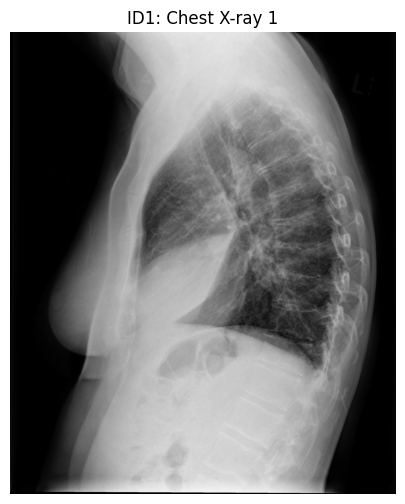


--- MedGemma Report ---

[{'role': 'system', 'content': [{'type': 'text', 'text': 'You are a board-certified radiologist.'}]}, {'role': 'user', 'content': [{'type': 'image', 'image': <PIL.Image.Image image mode=RGB size=2500x2996 at 0x7C3913B31BE0>}, {'type': 'text', 'text': 'Examine this chest radiograph and report:\n• Lungs & pleura (consolidation, edema, effusion, pneumothorax)\n• Cardiomediastinal contours (heart size, mediastinum)\n• Bones/soft tissues\nMention lines/devices if present. Provide a concise Impression with the leading diagnosis and key differentials.'}]}, {'role': 'assistant', 'content': 'Okay, I have reviewed the chest radiograph. Here is my report:\n\n**Findings:**\n\n*   **Lungs & Pleura:** There is a large right pleural effusion, obscuring the right hemidiaphragm and the right lung base. The left lung appears relatively clear. No pneumothorax is identified.\n*   **Cardiomediastinal Contours:** The heart size is normal. The mediastinum is unremarkable.\n*   **Bon

In [13]:
case_report = analyze_dicom_with_medgemma(ID1_image1, pipe, title="ID1: Chest X-ray 1")

In [14]:
formatted_text = format_case_report(case_report, title="ID1: Chest X-ray Report 1")


## ID1: Chest X-ray Report 1

Okay, I have reviewed the chest radiograph. Here is my report:

**Findings:**

- **Lungs & Pleura:** There is a large right pleural effusion, obscuring the right hemidiaphragm and the right lung base. The left lung appears relatively clear. No pneumothorax is identified.
- **Cardiomediastinal Contours:** The heart size is normal. The mediastinum is unremarkable.
- **Bones/Soft Tissues:** The bony structures are intact.

**Lines/Devices:**
- There are no lines or devices visible in this image.

**Impression:**
Large right pleural effusion.

**Differential Diagnosis:**
- Right-sided heart failure
- Nephrotic syndrome
- Malignancy
- Infection
- Pulmonary embolism
- Trauma

**Disclaimer:** This report is based solely on the provided image and is intended for informational purposes only. It is not a substitute for a comprehensive clinical evaluation and should not be used to make medical

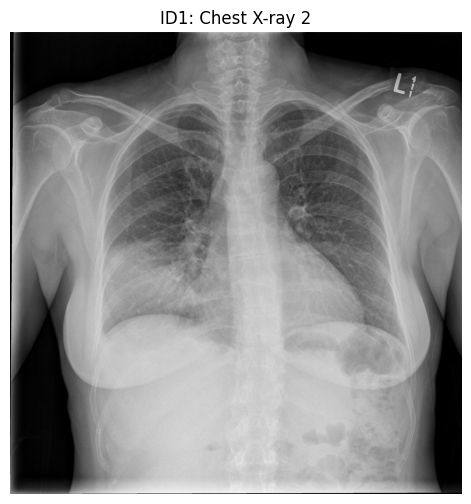


--- MedGemma Report ---

[{'role': 'system', 'content': [{'type': 'text', 'text': 'You are a board-certified radiologist.'}]}, {'role': 'user', 'content': [{'type': 'image', 'image': <PIL.Image.Image image mode=RGB size=2936x3001 at 0x7C3911237BF0>}, {'type': 'text', 'text': 'Examine this chest radiograph and report:\n• Lungs & pleura (consolidation, edema, effusion, pneumothorax)\n• Cardiomediastinal contours (heart size, mediastinum)\n• Bones/soft tissues\nMention lines/devices if present. Provide a concise Impression with the leading diagnosis and key differentials.'}]}, {'role': 'assistant', 'content': "Okay, I have reviewed the chest radiograph. Here's my report:\n\n**Findings:**\n\n*   **Lungs & Pleura:** There is a significant opacity in the right lower lung field, which could represent consolidation, atelectasis, or a mass. The left lung appears clear. No pleural effusion or pneumothorax is identified.\n\n*   **Cardiomediastinal Contours:** The heart size appears normal. The m

In [15]:
case_report = analyze_dicom_with_medgemma(ID1_image2, pipe, title="ID1: Chest X-ray 2")

In [16]:
formatted_text = format_case_report(case_report, title="ID1: Chest X-ray Report 2")

## ID1: Chest X-ray Report 2

Okay, I have reviewed the chest radiograph. Here's my report:

**Findings:**

- **Lungs & Pleura:** There is a significant opacity in the right lower lung field, which could represent consolidation, atelectasis, or a mass. The left lung appears clear. No pleural effusion or pneumothorax is identified.

- **Cardiomediastinal Contours:** The heart size appears normal. The mediastinum is unremarkable.

- **Bones/Soft Tissues:** The bony structures are intact.

- **Lines/Devices:**
No lines or devices are visible in the image.

**Impression:**
Right lower lung opacity, concerning for consolidation, atelectasis, or mass.

**Differential Diagnosis:**
- Pneumonia
- Atelectasis
- Lung Cancer
- Pulmonary embolism

**Disclaimer:** This report is based solely on the provided image and is for informational purposes only. It is not a substitute for a comprehensive clinical evaluation and further imaging studies may be necessary to

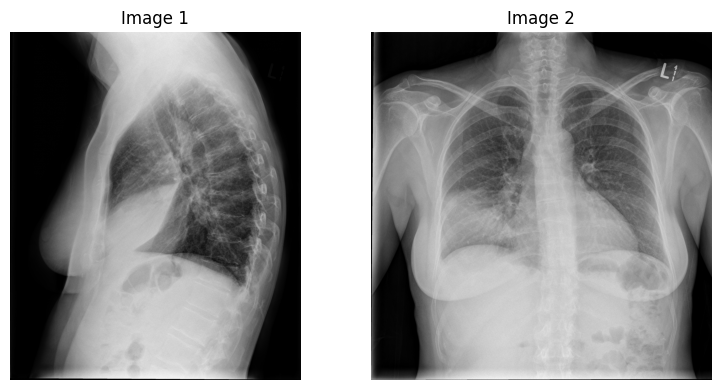


--- MedGemma Multi-Image Report ---

[{'role': 'system', 'content': [{'type': 'text', 'text': 'You are a board-certified radiologist.'}]}, {'role': 'user', 'content': [{'type': 'image', 'image': <PIL.Image.Image image mode=RGB size=2500x2996 at 0x7C39B4CCF830>}, {'type': 'image', 'image': <PIL.Image.Image image mode=RGB size=2936x3001 at 0x7C3913B8D8B0>}, {'type': 'text', 'text': 'You are given multiple chest radiographs of the same patient (for example PA and lateral or different projections).\n\nFor ALL images together, report:\n• Lungs & pleura (consolidation, edema, effusion, pneumothorax)\n• Cardiomediastinal contours (heart size, mediastinum)\n• Bones/soft tissues\nMention lines/devices if present.\n\nProvide a single concise Impression that integrates findings across all views, with the leading diagnosis and key differentials.'}]}, {'role': 'assistant', 'content': "Here's an impression based on the provided chest radiographs:\n\n**Impression:**\n\nThe patient has a right lower 

In [18]:
case_report = analyze_dicoms_with_medgemma([ID1_image1,ID1_image2], pipe)

In [19]:
formatted_text = format_case_report(case_report, title="ID1: multi-view")

## ID1: multi-view

Here's an impression based on the provided chest radiographs:

**Impression:**
The patient has a right lower lobe consolidation, likely pneumonia. The heart size is normal. The mediastinum is unremarkable. No pleural effusion or pneumothorax is identified.

**Detailed Findings:**

- **Lungs & Pleura:** Right lower lobe consolidation is present. The left lung appears clear. No pleural effusion or pneumothorax is seen.
- **Cardiomediastinal contours:** The heart size is normal. The mediastinum is unremarkable.
- **Bones/Soft Tissues:** No acute bony abnormalities are identified.

**Lines/Devices:**
- No lines or devices are visible in the images.

**Overall:**

The right lower lobe consolidation is the most significant finding. The differential diagnosis includes bacterial pneumonia, aspiration pneumonia, or other infectious processes. Further evaluation may be warranted to determine the etiology.

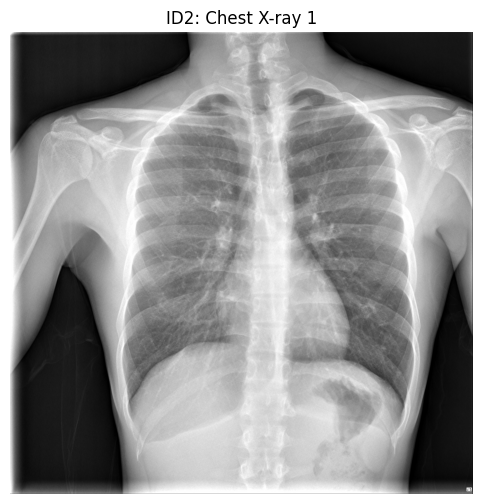


--- MedGemma Report ---

[{'role': 'system', 'content': [{'type': 'text', 'text': 'You are a board-certified radiologist.'}]}, {'role': 'user', 'content': [{'type': 'image', 'image': <PIL.Image.Image image mode=RGB size=2995x2991 at 0x7C39208043B0>}, {'type': 'text', 'text': 'Examine this chest radiograph and report:\n• Lungs & pleura (consolidation, edema, effusion, pneumothorax)\n• Cardiomediastinal contours (heart size, mediastinum)\n• Bones/soft tissues\nMention lines/devices if present. Provide a concise Impression with the leading diagnosis and key differentials.'}]}, {'role': 'assistant', 'content': "Okay, I have reviewed the chest radiograph. Here's my report:\n\n**Findings:**\n\n*   **Lungs & Pleura:** The lungs appear clear without evidence of consolidation, edema, effusion, or pneumothorax.\n*   **Cardiomediastinal contours:** The heart size is within normal limits. The mediastinum appears unremarkable.\n*   **Bones/Soft Tissues:** No acute fractures are identified.\n\n**Li

In [20]:
case_report = analyze_dicom_with_medgemma(ID2_image1, pipe, title="ID2: Chest X-ray 1")

In [21]:
formatted_text = format_case_report(case_report, title="ID2: Chest X-ray Report 1")

## ID2: Chest X-ray Report 1

Okay, I have reviewed the chest radiograph. Here's my report:

**Findings:**

- **Lungs & Pleura:** The lungs appear clear without evidence of consolidation, edema, effusion, or pneumothorax.
- **Cardiomediastinal contours:** The heart size is within normal limits. The mediastinum appears unremarkable.
- **Bones/Soft Tissues:** No acute fractures are identified.

**Lines/Devices:**
- There are no lines or devices visible in this image.

**Impression:**
Normal chest radiograph.

**Differential Diagnosis:**
- No acute cardiopulmonary pathology is evident.

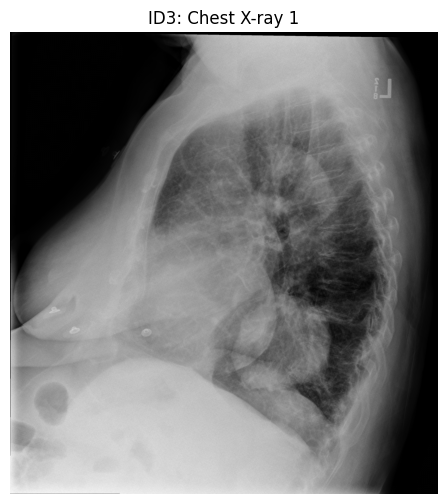


--- MedGemma Report ---

[{'role': 'system', 'content': [{'type': 'text', 'text': 'You are a board-certified radiologist.'}]}, {'role': 'user', 'content': [{'type': 'image', 'image': <PIL.Image.Image image mode=RGB size=2780x3001 at 0x7C39B4CE8AA0>}, {'type': 'text', 'text': 'Examine this chest radiograph and report:\n• Lungs & pleura (consolidation, edema, effusion, pneumothorax)\n• Cardiomediastinal contours (heart size, mediastinum)\n• Bones/soft tissues\nMention lines/devices if present. Provide a concise Impression with the leading diagnosis and key differentials.'}]}, {'role': 'assistant', 'content': "Okay, I have reviewed the chest radiograph. Here's my report:\n\n**Findings:**\n\n*   **Lungs & Pleura:** There is increased opacity in the right lung, particularly in the right lower lobe, which could represent consolidation, edema, or other process. The left lung appears relatively clear. No pleural effusion is evident. No pneumothorax is seen.\n\n*   **Cardiomediastinal Contours

In [22]:
case_report = analyze_dicom_with_medgemma(ID3_image1, pipe, title="ID3: Chest X-ray 1")

In [23]:
formatted_text = format_case_report(case_report, title="ID3: Chest X-ray Report 1")

## ID3: Chest X-ray Report 1

Okay, I have reviewed the chest radiograph. Here's my report:

**Findings:**

- **Lungs & Pleura:** There is increased opacity in the right lung, particularly in the right lower lobe, which could represent consolidation, edema, or other process. The left lung appears relatively clear. No pleural effusion is evident. No pneumothorax is seen.

- **Cardiomediastinal Contours:** The heart size appears normal. The mediastinum is unremarkable.

- **Bones/Soft Tissues:** The bony structures are intact.

- **Lines/Devices:**
There is a right-sided port-a-cath in place.

**Impression:**
Right lower lobe opacity, possibly representing consolidation, edema, or other process.

**Differential Diagnosis:**
- Pneumonia
- Pulmonary edema
- Atelectasis
- Mass

**Disclaimer:** This report is based solely on the provided image and is for informational purposes only. It does not constitute a complete medical evaluation. A

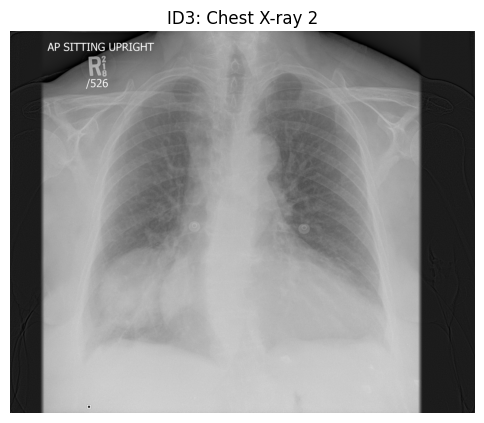


--- MedGemma Report ---

[{'role': 'system', 'content': [{'type': 'text', 'text': 'You are a board-certified radiologist.'}]}, {'role': 'user', 'content': [{'type': 'image', 'image': <PIL.Image.Image image mode=RGB size=4240x3480 at 0x7C39B4CC12E0>}, {'type': 'text', 'text': 'Examine this chest radiograph and report:\n• Lungs & pleura (consolidation, edema, effusion, pneumothorax)\n• Cardiomediastinal contours (heart size, mediastinum)\n• Bones/soft tissues\nMention lines/devices if present. Provide a concise Impression with the leading diagnosis and key differentials.'}]}, {'role': 'assistant', 'content': 'Okay, I have reviewed the chest radiograph. Here is my report:\n\n**Findings:**\n\n*   **Lungs & Pleura:** The lungs appear clear without evidence of consolidation, edema, effusion, or pneumothorax.\n*   **Cardiomediastinal contours:** The heart size is mildly enlarged. The mediastinum is unremarkable.\n*   **Bones/Soft Tissues:** No acute bony abnormalities are identified.\n\n**Li

In [24]:
case_report = analyze_dicom_with_medgemma(ID3_image2, pipe, title="ID3: Chest X-ray 2")

In [25]:
formatted_text = format_case_report(case_report, title="ID3: Chest X-ray Report 2")

## ID3: Chest X-ray Report 2

Okay, I have reviewed the chest radiograph. Here is my report:

**Findings:**

- **Lungs & Pleura:** The lungs appear clear without evidence of consolidation, edema, effusion, or pneumothorax.
- **Cardiomediastinal contours:** The heart size is mildly enlarged. The mediastinum is unremarkable.
- **Bones/Soft Tissues:** No acute bony abnormalities are identified.

**Lines/Devices:**
- There are no lines or devices visible in this image.

**Impression:**
- The radiograph is unremarkable.

**Differential Diagnosis:**
- The mild cardiomegaly could be due to various factors, including hypertension, coronary artery disease, or other cardiac conditions. Further evaluation may be needed to determine the underlying cause.

**Disclaimer:** This report is based solely on the provided image and is for informational purposes only. It does not constitute a complete medical evaluation. A definitive diagnosis requires a comprehensive clinical assessment and potentially additional imaging studies.

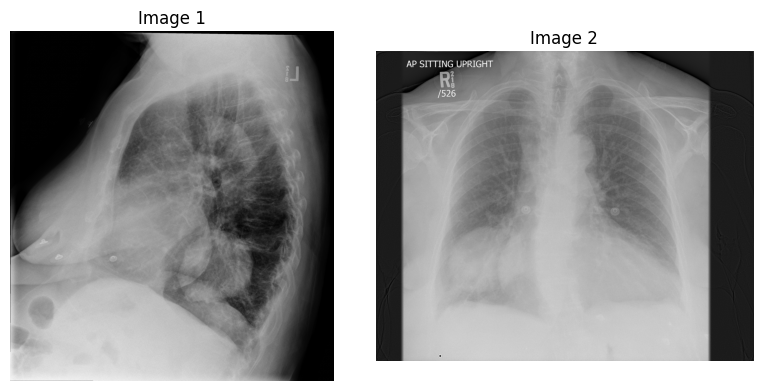


--- MedGemma Multi-Image Report ---

[{'role': 'system', 'content': [{'type': 'text', 'text': 'You are a board-certified radiologist.'}]}, {'role': 'user', 'content': [{'type': 'image', 'image': <PIL.Image.Image image mode=RGB size=2780x3001 at 0x7C39116D6660>}, {'type': 'image', 'image': <PIL.Image.Image image mode=RGB size=4240x3480 at 0x7C39115438C0>}, {'type': 'text', 'text': 'You are given multiple chest radiographs of the same patient (for example PA and lateral or different projections).\n\nFor ALL images together, report:\n• Lungs & pleura (consolidation, edema, effusion, pneumothorax)\n• Cardiomediastinal contours (heart size, mediastinum)\n• Bones/soft tissues\nMention lines/devices if present.\n\nProvide a single concise Impression that integrates findings across all views, with the leading diagnosis and key differentials.'}]}, {'role': 'assistant', 'content': "Here's an impression based on the provided chest radiographs:\n\n**Impression:**\n\nThe patient has a right-sided 

In [26]:
case_report = analyze_dicoms_with_medgemma([ID3_image1,ID3_image2], pipe)

In [27]:
formatted_text = format_case_report(case_report, title="ID3: multi-view")

## ID3: multi-view

Here's an impression based on the provided chest radiographs:

**Impression:**
The patient has a right-sided pleural effusion, which is likely the cause of the increased opacity in the right hemithorax. The heart size is normal. The mediastinum is unremarkable.

**Detailed Findings:**

- **Lungs & Pleura:** There is a significant right pleural effusion, obscuring the right hemidiaphragm and right lung markings. No pneumothorax is identified.
- **Cardiomediastinal contours:** The heart size is normal. The mediastinum is unremarkable.
- **Bones/Soft Tissues:** No acute bony abnormalities are identified.

**Lines/Devices:**
- No lines or devices are visible in the images.

**Overall Impression:**

Right-sided pleural effusion.

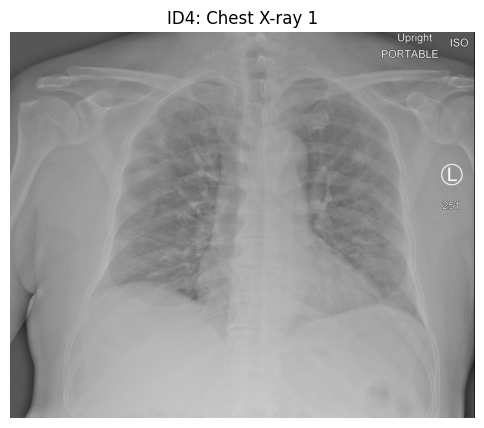


--- MedGemma Report ---

[{'role': 'system', 'content': [{'type': 'text', 'text': 'You are a board-certified radiologist.'}]}, {'role': 'user', 'content': [{'type': 'image', 'image': <PIL.Image.Image image mode=RGB size=3032x2520 at 0x7C391132C860>}, {'type': 'text', 'text': 'Examine this chest radiograph and report:\n• Lungs & pleura (consolidation, edema, effusion, pneumothorax)\n• Cardiomediastinal contours (heart size, mediastinum)\n• Bones/soft tissues\nMention lines/devices if present. Provide a concise Impression with the leading diagnosis and key differentials.'}]}, {'role': 'assistant', 'content': "Here's a report based on the provided chest radiograph:\n\n**Impression:**\n\nThe radiograph shows diffuse bilateral interstitial infiltrates, most prominent in the lung fields. The heart size is normal. The mediastinum is unremarkable. The bony structures are intact.\n\n**Lines/Devices:**\n\n*   There are no visible lines or devices in the image.\n\n**Differential Diagnosis:**\n\n

In [28]:
case_report = analyze_dicom_with_medgemma(ID4_image1, pipe, title="ID4: Chest X-ray 1")

In [29]:
formatted_text = format_case_report(case_report, title="ID4: Chest X-ray Report 1")

## ID4: Chest X-ray Report 1

Here's a report based on the provided chest radiograph:

**Impression:**
The radiograph shows diffuse bilateral interstitial infiltrates, most prominent in the lung fields. The heart size is normal. The mediastinum is unremarkable. The bony structures are intact.

**Lines/Devices:**
- There are no visible lines or devices in the image.

**Differential Diagnosis:**
- **Pneumonia:** The diffuse interstitial infiltrates are highly suggestive of pneumonia.
- **Acute Respiratory Distress Syndrome (ARDS):** The pattern could be consistent with ARDS, especially if there is a history of acute illness or trauma.
- **Pulmonary Edema:** Although less likely given the interstitial pattern, pulmonary edema should be considered, especially in the setting of heart failure or other cardiac conditions.
- **Aspiration Pneumonia:** Aspiration pneumonia can present with similar infiltrates.
- **Viral Pneumonia:** Viral infections can cause interstitial patterns.
- **Fungal Pneumonia:** Certain fungal infections can cause interstitial infiltrates.

###The JPG Dataset
Reference:
P. Eng and F.-K. Cheah, “Cases 1 to 100,” in Interpreting Chest X-Rays: Illustrated with 100 Cases, Cambridge: Cambridge University Press, 2005, pp. 1–200

In [30]:
# === Patient data loading utilities (run as a new cell) ===
import os, glob, re, textwrap
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

IMG_EXTS = (".png", ".jpg", ".jpeg", ".tif", ".tiff", ".bmp")
DATA_ROOT = os.path.abspath(os.path.join(os.getcwd(), "..", "data", "JPG"))
WRAP_WIDTH = 100  # adjust to taste (80–120 works well in Colab)

def _wrap(text: str, width: int = WRAP_WIDTH) -> str:
    """Soft-wrap long lines to fit the notebook output width."""
    if not text:
        return ""
    lines = text.splitlines()
    wrapped = [
        textwrap.fill(ln, width=width, break_long_words=False, replace_whitespace=False)
        if ln.strip() else ""
        for ln in lines
    ]
    return "\n".join(wrapped)

def _is_image(p: str) -> bool:
    return os.path.isfile(p) and p.lower().endswith(IMG_EXTS)

def _read_text(path: str):
    if path and os.path.isfile(path):
        with open(path, "r", encoding="utf-8", errors="ignore") as f:
            return f.read().strip()
    return None

def _find_text(patient_dir: str, keywords):
    """
    Return the first .txt whose filename contains any keyword (case-insensitive)
    from either patient_dir or patient_dir/text.
    """
    candidates = []
    # root .txt files
    for name in os.listdir(patient_dir):
        p = os.path.join(patient_dir, name)
        if os.path.isfile(p) and name.lower().endswith(".txt"):
            candidates.append(p)
    # text/ subdir
    tdir = os.path.join(patient_dir, "text")
    if os.path.isdir(tdir):
        for name in os.listdir(tdir):
            p = os.path.join(tdir, name)
            if os.path.isfile(p) and name.lower().endswith(".txt"):
                candidates.append(p)

    keys = tuple(k.lower() for k in keywords)
    for p in sorted(candidates):
        if any(k in os.path.basename(p).lower() for k in keys):
            return p
    return None

def _extract_impression_from_report(text: str):
    if not text:
        return None
    m = re.search(r"(impression\s*:?\s*)(.*)", text, flags=re.IGNORECASE | re.DOTALL)
    if not m:
        return None
    tail = m.group(2).strip()
    cut = re.split(r"\n[A-Z][A-Za-z ]{2,}:\s*\n", tail, maxsplit=1)
    return (cut[0] if cut else tail).strip()

def list_patients(data_root: str = DATA_ROOT):
    """Return sorted list of immediate subdirs under ../data/ as patient folders."""
    if not os.path.isdir(data_root):
        return []
    return sorted([p for p in glob.glob(os.path.join(data_root, "*")) if os.path.isdir(p)])

def _collect_all_images(patient_dir: str):
    """
    Collect image paths from the patient folder and common subfolders.
    """
    img_paths = []
    for name in os.listdir(patient_dir):
        p = os.path.join(patient_dir, name)
        if _is_image(p):
            img_paths.append(p)
    for sub in ("images", "img", "image", "cxr", "xray", "annot", "overlay"):
        sd = os.path.join(patient_dir, sub)
        if os.path.isdir(sd):
            for name in os.listdir(sd):
                p = os.path.join(sd, name)
                if _is_image(p):
                    img_paths.append(p)
    # unique + stable order
    return sorted(list(dict.fromkeys(img_paths)))

def _looks_annotated(path: str) -> bool:
    """
    Heuristics to label an image as 'annotated'.
    Triggers if filename or parent folder suggests annotation/overlay/mask/boxes.
    """
    name = os.path.basename(path).lower()
    parent = os.path.basename(os.path.dirname(path)).lower()
    hints = ("annot", "overlay", "mask", "label", "bbox", "boxes", "marked", "box", "seg", "contour")
    return any(h in name for h in hints) or any(h in parent for h in hints)

def load_patient(patient_dir: str, show_images: bool = True, max_images: int | None = None):
    """
    Loads one patient folder:
      - Reads question (question/history) and impression (impression or parsed from report)
      - Loads images as grayscale and separates:
            image            -> the 'base' CXR
            image_annotated  -> the annotated/overlay CXR (if present)
        Remaining images (if any) are returned in 'others'.
      - Prints question & impression (wrapped to fit window)
      - Prints per-image size (WxH) and max intensity
      - Plots each image (one figure per image, grayscale)

    Returns dict:
      {
        'patient_dir': str,
        'question_text': str|None,
        'impression_text': str|None,
        'image': (path, PIL.Image, np.ndarray) | None,
        'image_annotated': (path, PIL.Image, np.ndarray) | None,
        'others': list[(path, PIL.Image, np.ndarray)]
      }
    """
    patient_dir = os.path.abspath(patient_dir)

    # --- Texts ---
    qfile = _find_text(patient_dir, keywords=("question", "history", "clinical_question"))
    ifile = _find_text(patient_dir, keywords=("impression", "final_impression"))

    question_text = _read_text(qfile)
    impression_text = _read_text(ifile)

    if impression_text is None:
        # Parse from a generic report as fallback
        rpt_file = _find_text(patient_dir, keywords=("report", "cxr", "findings", "conclusion", "result"))
        rpt_text = _read_text(rpt_file)
        impression_text = _extract_impression_from_report(rpt_text) or rpt_text

    print(f"\n=== PATIENT: {os.path.basename(patient_dir)} ===")
    print("\n--- Question ---")
    print(_wrap(question_text) if question_text else "[Not found] Add question.txt or history.txt")

    print("\n--- Impression ---")
    print(_wrap(impression_text) if impression_text else "[Not found] Add impression.txt or a report with an 'Impression' section")

    # --- Images (grayscale) ---
    img_paths = _collect_all_images(patient_dir)
    if max_images is not None:
        img_paths = img_paths[:max_images]

    if not img_paths:
        print("\n[No images found] Place images in the patient folder or a subfolder like 'images/'.")
        return {
            "patient_dir": patient_dir,
            "question_text": question_text,
            "impression_text": impression_text,
            "image": None,
            "image_annotated": None,
            "others": [],
        }

    # Separate annotated vs base via heuristics
    ann_candidates = [p for p in img_paths if _looks_annotated(p)]
    base_candidates = [p for p in img_paths if p not in ann_candidates]

    # Fallback pairing if heuristics find nothing but at least 2 images
    image_path = None
    image_ann_path = None

    if ann_candidates and base_candidates:
        # Choose the first base as image, first annotated as image_annotated
        image_path = base_candidates[0]
        image_ann_path = ann_candidates[0]
        remaining = [p for p in img_paths if p not in (image_path, image_ann_path)]
    elif len(img_paths) >= 2:
        # No strong hints: assume [0]=image, [1]=image_annotated
        image_path, image_ann_path = img_paths[0], img_paths[1]
        remaining = img_paths[2:]
    else:
        # Only one image available
        image_path = img_paths[0]
        remaining = img_paths[1:]
        image_ann_path = None

    # Load & report
    def _load_gray(pth):
        img = Image.open(pth).convert("L")
        arr = np.array(img)
        h, w = arr.shape
        max_val = int(arr.max()) if arr.size else None
        print(f"• {os.path.basename(pth)}  size: {w}x{h}  max_intensity: {max_val}")
        if show_images:
            plt.figure(figsize=(6, 6))
            plt.imshow(arr, cmap="gray")
            plt.title(os.path.basename(pth))
            plt.axis("off")
            plt.show()
        return (pth, img, arr)

    print("\n--- Image Stats (grayscale) ---")
    image = _load_gray(image_path) if image_path else None
    image_annotated = _load_gray(image_ann_path) if image_ann_path else None

    others = []
    for p in remaining:
        try:
            others.append(_load_gray(p))
        except Exception as e:
            print(f"[WARN] Could not load {p}: {e}")

    return {
        "patient_dir": patient_dir,
        "question_text": question_text,
        "impression_text": impression_text,
        "image": image,
        "image_annotated": image_annotated,
        "others": others,
    }

In [31]:
def load_patient(patient_dir: str, show_images: bool = True, max_images: int | None = None):
    """
    Loads one patient folder:
      - Reads question (question/history) and impression (impression or parsed from report)
      - Loads images as grayscale and separates:
            image           -> the 'base' CXR
            image_support   -> the supporting/annotated/overlay CXR (if present)
        Remaining images (if any) are returned in 'others'.
      - Prints question & impression (wrapped to fit window)
      - Prints per-image size (WxH) and max intensity
      - Plots each image (one figure per image, grayscale)

    Returns dict:
      {
        'patient_dir': str,
        'question_text': str|None,
        'impression_text': str|None,
        'image': (path, PIL.Image, np.ndarray) | None,
        'image_support': (path, PIL.Image, np.ndarray) | None,
        'others': list[(path, PIL.Image, np.ndarray)]
      }
    """
    patient_dir = os.path.abspath(patient_dir)

    # --- Texts ---
    qfile = _find_text(patient_dir, keywords=("question", "history", "clinical_question"))
    ifile = _find_text(patient_dir, keywords=("impression", "final_impression"))

    question_text = _read_text(qfile)
    impression_text = _read_text(ifile)

    if impression_text is None:
        # Parse from a generic report as fallback
        rpt_file = _find_text(patient_dir, keywords=("report", "cxr", "findings", "conclusion", "result"))
        rpt_text = _read_text(rpt_file)
        impression_text = _extract_impression_from_report(rpt_text) or rpt_text

    print(f"\n=== PATIENT: {os.path.basename(patient_dir)} ===")
    print("\n--- Question ---")
    print(_wrap(question_text) if question_text else "[Not found] Add question.txt or history.txt")

    print("\n--- Impression ---")
    print(_wrap(impression_text) if impression_text else "[Not found] Add impression.txt or a report with an 'Impression' section")

    # --- Images (grayscale) ---
    img_paths = _collect_all_images(patient_dir)
    if max_images is not None:
        img_paths = img_paths[:max_images]

    if not img_paths:
        print("\n[No images found] Place images in the patient folder or a subfolder like 'images/'.")
        return {
            "patient_dir": patient_dir,
            "question_text": question_text,
            "impression_text": impression_text,
            "image": None,
            "image_support": None,
            "others": [],
        }

    # Separate annotated vs base via heuristics
    ann_candidates = [p for p in img_paths if _looks_annotated(p)]
    base_candidates = [p for p in img_paths if p not in ann_candidates]

    # Fallback pairing if heuristics find nothing but at least 2 images
    image_path = None
    image_support_path = None

    if ann_candidates and base_candidates:
        image_path = base_candidates[0]
        image_support_path = ann_candidates[0]
        remaining = [p for p in img_paths if p not in (image_path, image_support_path)]
    elif len(img_paths) >= 2:
        image_path, image_support_path = img_paths[0], img_paths[1]
        remaining = img_paths[2:]
    else:
        image_path = img_paths[0]
        remaining = img_paths[1:]
        image_support_path = None

    # Load & report
    def _load_gray(pth):
        img = Image.open(pth).convert("L")
        arr = np.array(img)
        h, w = arr.shape
        max_val = int(arr.max()) if arr.size else None
        print(f"• {os.path.basename(pth)}  size: {w}x{h}  max_intensity: {max_val}")
        if show_images:
            plt.figure(figsize=(6, 6))
            plt.imshow(arr, cmap="gray")
            plt.title(os.path.basename(pth))
            plt.axis("off")
            plt.show()
        return (pth, img, arr)

    print("\n--- Image Stats (grayscale) ---")
    image = _load_gray(image_path) if image_path else None
    image_support = _load_gray(image_support_path) if image_support_path else None

    others = []
    for p in remaining:
        try:
            others.append(_load_gray(p))
        except Exception as e:
            print(f"[WARN] Could not load {p}: {e}")

    return {
        "patient_dir": patient_dir,
        "question_text": question_text,
        "impression_text": impression_text,
        "image": image,
        "image_support": image_support,
        "others": others,
    }


In [32]:
patients = list_patients() # discover ../data/JPG/<PATIENT_ID>/
print(patients)


['/content/drive/MyDrive/IMPACT_Med_2025/data/JPG/Patient1', '/content/drive/MyDrive/IMPACT_Med_2025/data/JPG/Patient2', '/content/drive/MyDrive/IMPACT_Med_2025/data/JPG/Patient3']



=== PATIENT: Patient1 ===

--- Question ---
Case 1. A 35-year-old male presented with fever, cough, and purulentsputum for one week. This was
his CXR. What is the diagnosis?

--- Impression ---
CASE 1 PNEUMONIAThe CXR shows a focal shadow in the right lower lobe with air bronchograms sug-
gestive of pneumonia. It is clearly in the right lower lobe because the right hemidi-aphragm is
eﬀaced. Right middle lobe shadows would eﬀace the right heart border.The presence of air
bronchograms indicates pathology in the alveoli, as the con-ducting airways remain patent with air.
Water or blood can also occupy the alveolias a result of pulmonary edema or pulmonary hemorrhage
respectively. Thereshould be other supporting signs such as cardiomegaly, upper lobe diversion,
andKerley B lines with pulmonary edema. The diﬀerential diagnoses of a focal shadowwith air
bronchograms include bronchoalveolar cell carcinoma and lymphoma. Itis important to follow-up the
CXR to ensure that total resolution of in

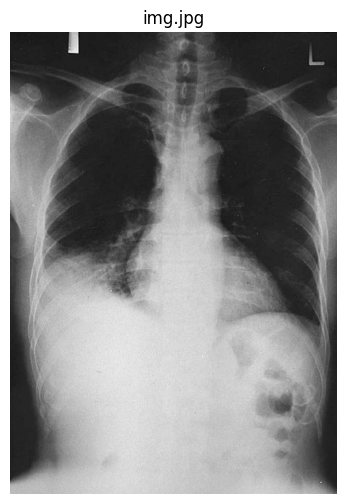

• img_support.jpg  size: 387x472  max_intensity: 255


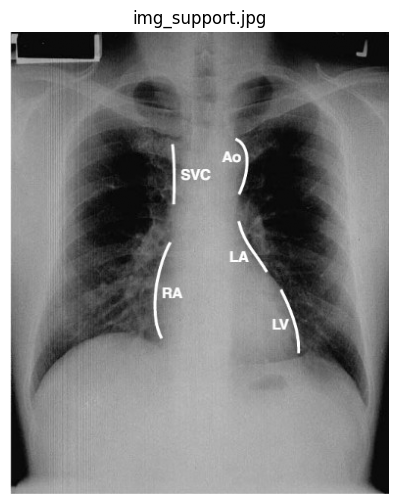

In [33]:
patient_data = load_patient(patients[0]) # load & display the first patient data


In [34]:
import os, re
from PIL import Image

RESULTS_DIR = os.path.abspath(os.path.join(os.getcwd(), "..", "results"))
os.makedirs(RESULTS_DIR, exist_ok=True)

system_instruction = "You are an expert thoracic radiologist. Write a concise, evidence-based Impression."

def _pick_images(pd):
    """Return (image_base, image_support) as PIL.Image or None."""
    image_base = pd["image"][1] if pd.get("image") and isinstance(pd["image"], tuple) else None
    image_support = pd["image_support"][1] if pd.get("image_support") and isinstance(pd["image_support"], tuple) else None
    if image_base is None and pd.get("others"):
        image_base = pd["others"][0][1]
    return image_base, image_support

def _extract_text(out):
    """Make sure we always return a plain string from various HF pipeline outputs."""
    # Common case: list with dict having 'generated_text'
    if isinstance(out, list) and out:
        item = out[0]
        if isinstance(item, dict):
            if "generated_text" in item and isinstance(item["generated_text"], str):
                return item["generated_text"]
            if "text" in item and isinstance(item["text"], str):
                return item["text"]
            # Some chat-like returns: {'role': 'assistant', 'content': [...]}
            if "content" in item:
                c = item["content"]
                if isinstance(c, list):
                    # Join any text blocks
                    texts = [part.get("text") for part in c if isinstance(part, dict) and part.get("type") == "text"]
                    texts = [t for t in texts if isinstance(t, str)]
                    if texts:
                        return "\n".join(texts)
                if isinstance(c, str):
                    return c
        # List of strings?
        if all(isinstance(x, str) for x in out):
            return "\n".join(out)
    # Plain dict?
    if isinstance(out, dict):
        if "generated_text" in out and isinstance(out["generated_text"], str):
            return out["generated_text"]
        if "text" in out and isinstance(out["text"], str):
            return out["text"]
        if "content" in out:
            c = out["content"]
            if isinstance(c, str):
                return c
            if isinstance(c, list):
                texts = [part.get("text") for part in c if isinstance(part, dict) and part.get("type") == "text"]
                texts = [t for t in texts if isinstance(t, str)]
                if texts:
                    return "\n".join(texts)
    # Fallback
    return str(out)

def _run_medgemma(pipe, prompt, image_base=None, image_annot=None, max_new_tokens=180):
    """
    Build the chat-style message (system + user + 1-2 images) and run inference.
    Always returns a string.
    """
    image_base = image_base.convert("RGB") if image_base else None
    image_annot = image_annot.convert("RGB") if image_annot else None

    messages = [
        {"role": "system", "content": [{"type": "text", "text": system_instruction}]},
        {"role": "user", "content":
            [{"type": "text", "text": prompt}]
            + ([{"type": "image", "image": image_base}] if image_base else [])
            + ([{"type": "image", "image": image_annot}] if image_annot else [])
        },
    ]
    try:
        out = pipe(text=messages, max_new_tokens=max_new_tokens)
    except Exception:
        try:
            # Fallback to <image> token format
            if image_base:
                out = pipe(text="<image>\n" + prompt, images=image_base, max_new_tokens=max_new_tokens)
            else:
                out = pipe(text=prompt, max_new_tokens=max_new_tokens)
        except Exception as e:
            out = {"text": f"[Pipeline error] {e}"}

    return _extract_text(out)

def _format_simple(text: str) -> str:
    """Minimal tidy-up to make files readable."""
    if not isinstance(text, str):
        text = _extract_text(text)
    t = text.replace("\\n", "\n").strip()
    # Put common headers on their own lines
    t = re.sub(r"\s*\*\*(Impression|Lines/Devices|Differential Diagnosis)\:\*\*\s*", r"\n\n**\1:**\n", t)
    # Normalize bullets
    t = t.replace("•", "-")
    t = re.sub(r"(^|\n)\*\s+", r"\1- ", t)
    # Collapse excessive newlines
    t = re.sub(r"\n{3,}", "\n\n", t)
    return t.strip()

# ---------- Iterate over all patients, infer, and save ----------
patients = list_patients()
print(f"Found {len(patients)} patients. Writing reports to: {RESULTS_DIR}\n")

for pdir in patients:
    pid = os.path.basename(pdir.rstrip("/"))
    try:
        pdict = load_patient(pdir, show_images=False, max_images=2)
        image_base, image_support = _pick_images(pdict)

        if image_base is None:
            print(f"[{pid}] No image found — skipping.")
            continue

        # Your prompt logic
        prompt = (pdict.get("question_text") or "Describe the key chest X-ray findings and provide an Impression.").strip()

        raw_report = _run_medgemma(pipe, prompt, image_base, image_support, max_new_tokens=220)
        report = _format_simple(raw_report)

        out_path = os.path.join(RESULTS_DIR, f"{pid}.txt")
        with open(out_path, "w", encoding="utf-8") as f:
            f.write(f"Patient: {pid}\n\n")
            if pdict.get("question_text"):
                f.write("Question:\n" + pdict["question_text"].strip() + "\n\n")
            f.write("MedGemma Report:\n")
            f.write(report + "\n")

        print(f"[{pid}] Saved report to {out_path}")
    except Exception as e:
        print(f"[{pid}] Error: {e}")


Found 3 patients. Writing reports to: /content/drive/MyDrive/IMPACT_Med_2025/results


=== PATIENT: Patient1 ===

--- Question ---
Case 1. A 35-year-old male presented with fever, cough, and purulentsputum for one week. This was
his CXR. What is the diagnosis?

--- Impression ---
CASE 1 PNEUMONIAThe CXR shows a focal shadow in the right lower lobe with air bronchograms sug-
gestive of pneumonia. It is clearly in the right lower lobe because the right hemidi-aphragm is
eﬀaced. Right middle lobe shadows would eﬀace the right heart border.The presence of air
bronchograms indicates pathology in the alveoli, as the con-ducting airways remain patent with air.
Water or blood can also occupy the alveolias a result of pulmonary edema or pulmonary hemorrhage
respectively. Thereshould be other supporting signs such as cardiomegaly, upper lobe diversion,
andKerley B lines with pulmonary edema. The diﬀerential diagnoses of a focal shadowwith air
bronchograms include bronchoalveolar cell carcinoma a

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


• img_support.jpg  size: 1582x1098  max_intensity: 255
[Patient3] Saved report to /content/drive/MyDrive/IMPACT_Med_2025/results/Patient3.txt
